# Modeling

## Import Libraries

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import joblib
import time

# import model
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn import tree

# import model metric
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay, PrecisionRecallDisplay

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

import sys
sys.path.append('../src')  
import utils as util

In [79]:
all_attributes = dir(util)

user_defined = [attr for attr in all_attributes if not attr.startswith('_')]

for attr in user_defined:
    print(attr)

COBA
datetime
joblib
load_config
pickle_dump
pickle_load
yaml


## Load Configuration File

In [61]:
config_data = util.load_config()

## Load Train and Test Data

In [55]:
X_train_path = '../' + config_data['train_test_data']['directory'] + config_data['train_test_data']['X_train']
y_train_path = '../' + config_data['train_test_data']['directory'] + config_data['train_test_data']['y_train']

X_test_path = '../' + config_data['train_test_data']['directory'] + config_data['train_test_data']['X_test']
y_test_path = '../' + config_data['train_test_data']['directory'] + config_data['train_test_data']['y_test']

X_train_feng_path = '../' + config_data['train_test_data']['directory'] + config_data['train_test_data']['X_train_feng']
y_train_feng_path = '../' + config_data['train_test_data']['directory'] + config_data['train_test_data']['y_train_feng']

X_test_feng_path = '../' + config_data['train_test_data']['directory'] + config_data['train_test_data']['X_test_feng']
y_test_feng_path = '../' + config_data['train_test_data']['directory'] + config_data['train_test_data']['y_test_feng']


# load all train and test data
X_train = joblib.load(X_train_path)
y_train = joblib.load(y_train_path)

X_test = joblib.load(X_test_path)
y_test = joblib.load(y_test_path)

X_train_feng = joblib.load(X_train_feng_path)
y_train_feng = joblib.load(y_train_feng_path)

X_test_feng = joblib.load(X_test_feng_path)
y_test_feng = joblib.load(y_test_feng_path)

## Baseline Model

In [9]:
base_model = DummyClassifier(strategy = 'most_frequent')
base_model.fit(X_train_feng['WithoutResampling'], y_train_feng['WithoutResampling'])
y_test_pred = base_model.predict(X_test_feng)

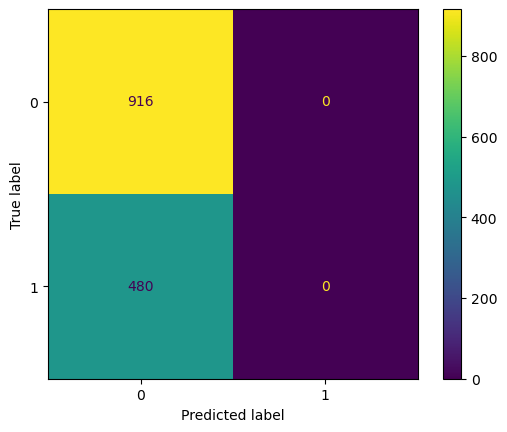

In [10]:
ConfusionMatrixDisplay.from_predictions(y_test_feng, y_test_pred)

plt.show()

In [11]:
print(classification_report(y_true = y_test_feng, y_pred = y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.66      1.00      0.79       916
           1       0.00      0.00      0.00       480

    accuracy                           0.66      1396
   macro avg       0.33      0.50      0.40      1396
weighted avg       0.43      0.66      0.52      1396



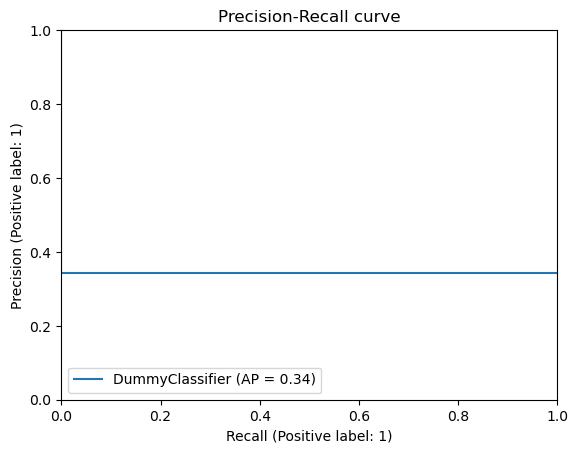

In [12]:
display = PrecisionRecallDisplay.from_estimator(base_model, X_test_feng, y_test_feng)
_ = display.ax_.set_title('Precision-Recall curve')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

In [13]:
ls_model = [DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, XGBClassifier]

ls_train_data = {'WithoutResampling': (X_train_feng['WithoutResampling'], y_train_feng['WithoutResampling']),
                 'Undersampling' : (X_train_feng['Undersampling'], y_train_feng['Undersampling']), 
                 'Oversampling' : (X_train_feng['Oversampling'], y_train_feng['Oversampling']),
                 'SMOTE' : (X_train_feng['SMOTE'], y_train_feng['SMOTE'])}

In [14]:
df_metriks = pd.DataFrame(columns = ['resampling_method', 'model', 'train_f1_score', 'test_f1_score', 'train_time'])

for key, values in ls_train_data.items():
    for model in ls_model:
        model_ = model(random_state = config_data['ls_model']['random_state'][0])

        train_time_t0 = time.time()
        model_.fit(values[0], values[1])
        train_time_t1 = time.time()
        train_time = train_time_t1 - train_time_t0

        y_train_pred = model_.predict(values[0])
        train_f1_score = f1_score(y_train_pred, values[1])
        
        y_test_pred = model_.predict(X_test_feng)
        test_f1_score = f1_score(y_test_pred, y_test_feng)
        
        ls_log = pd.DataFrame({'resampling_method': [key], 
                    'model': [model.__name__], 
                    'train_f1_score': [train_f1_score], 
                    'test_f1_score': [test_f1_score],
                    'train_time': [train_time]})
        df_metriks = df_metriks.dropna(axis=1, how='all')
        ls_log = ls_log.dropna(axis=1, how='all')

        df_metriks = pd.concat([df_metriks, ls_log], ignore_index=True)

df_metriks = df_metriks.sort_values('test_f1_score', ascending=False).reset_index().drop('index', axis = 1)
df_metriks

,resampling_method,model,train_f1_score,test_f1_score,train_time
0,SMOTE,GradientBoostingClassifier,0.849260,0.760405,0.219215
1,Oversampling,GradientBoostingClassifier,0.811988,0.760043,0.194960
2,Undersampling,GradientBoostingClassifier,0.817476,0.751323,0.138759
3,WithoutResampling,XGBClassifier,0.855172,0.744875,0.254327
4,WithoutResampling,GradientBoostingClassifier,0.766240,0.744019,0.234210
5,SMOTE,XGBClassifier,0.907125,0.730263,0.067742
6,SMOTE,RandomForestClassifier,0.933910,0.727655,0.223173
7,Oversampling,XGBClassifier,0.902676,0.724947,0.078373
8,WithoutResampling,RandomForestClassifier,0.899858,0.721491,0.196727
9,Undersampling,XGBClassifier,0.893195,0.720081,0.116616


## Cross-validation and Hyperparameter Tuning 

In [16]:
X_train_path = '../' + config_data['train_test_data']['directory'] + config_data['train_test_data']['X_train']
X_train = joblib.load(X_train_path)

In [17]:
X_train.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain
588,Bachelors,2014,Bangalore,3,27,Male,No,5
2638,Masters,2017,New Delhi,2,30,Female,No,2
4592,Bachelors,2013,New Delhi,3,28,Female,No,0
1966,Bachelors,2013,Pune,3,24,Female,No,2
171,Bachelors,2015,Pune,3,25,Male,No,3


In [19]:
cat_features = config_data['data_source']['cat_features']
num_features = config_data['data_source']['num_features']

cat_transformer = Pipeline(steps = [('Imputer_nan', SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value='UNKNOWN')),
                                    ('Imputer_cat', SimpleImputer(missing_values='', strategy='constant', fill_value='UNKNOWN')),
                                    ('OHE', OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features)
    ]
)

In [20]:
ls_model = [DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, XGBClassifier]

ls_params = {
    'dt': {'classifier__criterion': config_data['ls_model']['dt']['criterion'],
           'classifier__max_depth': config_data['ls_model']['dt']['max_depth'], 
           'classifier__min_samples_split': config_data['ls_model']['dt']['min_samples_split'], 
           'classifier__class_weight': config_data['ls_model']['dt']['class_weight'],
           'classifier__random_state': config_data['ls_model']['random_state']},
    'rf': {'classifier__n_estimators': config_data['ls_model']['rf']['n_estimators'], 
           'classifier__min_samples_split': config_data['ls_model']['rf']['min_samples_split'], 
           'classifier__class_weight': config_data['ls_model']['rf']['class_weight'],
           'classifier__random_state': config_data['ls_model']['random_state']},
    'ab': {'classifier__n_estimators': config_data['ls_model']['ab']['n_estimators'], 
           'classifier__learning_rate': config_data['ls_model']['ab']['learning_rate'],
           'classifier__random_state': config_data['ls_model']['random_state']},
    'gb': {'classifier__loss': config_data['ls_model']['gb']['loss'], 
           'classifier__n_estimators': config_data['ls_model']['gb']['n_estimators'], 
           'classifier__learning_rate': config_data['ls_model']['gb']['learning_rate'], 
           'classifier__max_features': config_data['ls_model']['gb']['max_features'],
           'classifier__random_state': config_data['ls_model']['random_state']},
    'xgb': {'classifier__max_depth': config_data['ls_model']['xgb']['max_depth'], 
            'classifier__learning_rate': config_data['ls_model']['xgb']['learning_rate'], 
            'classifier__sampling_method': config_data['ls_model']['xgb']['sampling_method'],
            'classifier__random_state': config_data['ls_model']['random_state']}
}
ls_sampler = [None, RandomUnderSampler, RandomOverSampler, SMOTE]

In [21]:
ls_cv_result = []

for model, params in zip(ls_model, ls_params):
    for sampler in ls_sampler:
        
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model())])
        
        clf = GridSearchCV(estimator = pipeline, param_grid = ls_params[params], cv = 5, scoring = 'f1', return_train_score = True)
        clf.fit(X_train, y_train_feng['WithoutResampling'])
        
        cv_results = pd.DataFrame(clf.cv_results_)
        cv_results = pd.DataFrame(clf.cv_results_)[['params', 'mean_train_score', 'mean_test_score', 'mean_fit_time']]
        cv_results = cv_results.rename(columns = {'mean_train_score': 'train_f1_score',
                                                  'mean_test_score': 'test_f1_score',
                                                  'mean_fit_time': 'train_time'})
        cv_results['model'] = model.__name__
        cv_results['resampling_method'] = sampler.__name__ if sampler != None else 'WithoutResampling'
        
        ls_cv_result.append(cv_results)
        
train_log = pd.concat(ls_cv_result, ignore_index=True)
train_log = train_log[['resampling_method', 'model', 'params', 'train_f1_score', 'test_f1_score', 'train_time']]
train_log = train_log.sort_values('test_f1_score', ascending = False).reset_index().drop(['index'], axis = 1)
train_log

,resampling_method,model,params,train_f1_score,test_f1_score,train_time
0,WithoutResampling,GradientBoostingClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.782078,0.756426,0.221977
1,RandomUnderSampler,GradientBoostingClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.782078,0.756426,0.240136
2,RandomOverSampler,GradientBoostingClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.782078,0.756426,0.211726
3,SMOTE,GradientBoostingClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.782078,0.756426,0.225142
4,RandomOverSampler,GradientBoostingClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.776938,0.752272,0.268311
...,...,...,...,...,...,...
283,RandomUnderSampler,XGBClassifier,"{'classifier__learning_rate': 0.001, 'classifi...",0.000000,0.000000,0.058793
284,WithoutResampling,GradientBoostingClassifier,"{'classifier__learning_rate': 0.001, 'classifi...",0.000000,0.000000,0.080797
285,WithoutResampling,GradientBoostingClassifier,"{'classifier__learning_rate': 0.001, 'classifi...",0.000000,0.000000,0.142804
286,WithoutResampling,GradientBoostingClassifier,"{'classifier__learning_rate': 0.001, 'classifi...",0.000000,0.000000,0.209505


In [22]:
best_model = train_log.iloc[train_log[['resampling_method', 'model', 'test_f1_score']].groupby(['resampling_method', 'model']).idxmax()\
                            .loc[:,'test_f1_score']]\
                            .sort_values('test_f1_score', ascending = False)\
                            .reset_index()\
                            .drop(['index'], axis = 1)
best_model

,resampling_method,model,params,train_f1_score,test_f1_score,train_time
0,RandomOverSampler,GradientBoostingClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.782078,0.756426,0.211726
1,RandomUnderSampler,GradientBoostingClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.782078,0.756426,0.240136
2,SMOTE,GradientBoostingClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.782078,0.756426,0.225142
3,WithoutResampling,GradientBoostingClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.782078,0.756426,0.221977
4,WithoutResampling,DecisionTreeClassifier,"{'classifier__class_weight': 'balanced', 'clas...",0.778082,0.751381,0.009490
5,RandomUnderSampler,DecisionTreeClassifier,"{'classifier__class_weight': 'balanced', 'clas...",0.778082,0.751381,0.010775
6,RandomOverSampler,DecisionTreeClassifier,"{'classifier__class_weight': 'balanced', 'clas...",0.778082,0.751381,0.009939
7,SMOTE,DecisionTreeClassifier,"{'classifier__class_weight': 'balanced', 'clas...",0.778082,0.751381,0.009683
8,WithoutResampling,XGBClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.791468,0.748994,0.046650
9,RandomOverSampler,XGBClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.791468,0.748994,0.034998


## Evaluation

In [ ]:
ls_train_data = {'WithoutResampling': (X_train_feng['WithoutResampling'], y_train_feng['WithoutResampling']),
                 'Undersampling' : (X_train_feng['Undersampling'], y_train_feng['Undersampling']), 
                 'Oversampling' : (X_train_feng['Oversampling'], y_train_feng['Oversampling']),
                 'SMOTE' : (X_train_feng['SMOTE'], y_train_feng['SMOTE'])}

In [35]:
columns = ['resampling_method', 'model', 'params', 'train_f1_score', 'test_f1_score', 'train_time']
ls_eval_result = []

for model in ls_model:
    for sampler in ls_sampler:
        i = best_model[best_model['model'] == model.__name__].index.values[0]
        
        param = {key[12:]:value for (key, value) in best_model.iloc[i].params.items()}
        clf = model(**param)
        
        if sampler == None:
            resampling_method = 'WithoutResampling'
            X_train_eval = X_train_feng['WithoutResampling']
            y_train_eval = y_train_feng['WithoutResampling']

        elif sampler == RandomUnderSampler:
            resampling_method = RandomUnderSampler.__name__
            X_train_eval = X_train_feng['Undersampling']
            y_train_eval = y_train_feng['Undersampling']

        elif sampler == RandomOverSampler:
            resampling_method = RandomOverSampler.__name__
            X_train_eval = X_train_feng['Oversampling']
            y_train_eval = y_train_feng['Oversampling']
            
        elif sampler == SMOTE:
            resampling_method = RandomOverSampler.__name__
            X_train_eval = X_train_feng['SMOTE']
            y_train_eval = y_train_feng['SMOTE']

        else:
            assert ValueError(f"There's no {best_model.iloc[i]['resampling_method']} resampling method in the list")
        
        train_time_t0 = time.time()
        clf.fit(X_train_eval, y_train_eval)
        train_time_t1 = time.time()
        train_time = train_time_t1 - train_time_t0
        
        y_train_pred = clf.predict(X_train_feng['WithoutResampling'])
        y_test_pred = clf.predict(X_test_feng)

        score = {'resampling_method' : [resampling_method],
                 'model': [best_model.iloc[i]['model']],
                 'params': [param],
                 'train_f1_score': [f1_score(y_train_feng['WithoutResampling'], y_train_pred)],
                 'test_f1_score': [f1_score(y_test_feng, y_test_pred)],
                 'train_time': [train_time]
                }
        ls_eval_result.append(pd.DataFrame(score, columns = columns))


evaluation_metrics = pd.concat(ls_eval_result, ignore_index = True)
evaluation_metrics = evaluation_metrics.sort_values(['test_f1_score'], ascending=False).reset_index().drop(['index'], axis = 1)
evaluation_metrics

,resampling_method,model,params,train_f1_score,test_f1_score,train_time
0,RandomOverSampler,DecisionTreeClassifier,"{'class_weight': 'balanced', 'criterion': 'ent...",0.778409,0.778390,0.006458
1,RandomOverSampler,XGBClassifier,"{'learning_rate': 0.1, 'max_depth': 5, 'random...",0.792360,0.769759,0.065628
2,WithoutResampling,XGBClassifier,"{'learning_rate': 0.1, 'max_depth': 5, 'random...",0.790061,0.762353,0.058347
3,RandomOverSampler,GradientBoostingClassifier,"{'learning_rate': 0.1, 'loss': 'log_loss', 'ma...",0.781463,0.761364,0.296156
4,RandomOverSampler,DecisionTreeClassifier,"{'class_weight': 'balanced', 'criterion': 'ent...",0.789246,0.761161,0.006441
5,RandomOverSampler,GradientBoostingClassifier,"{'learning_rate': 0.1, 'loss': 'log_loss', 'ma...",0.791199,0.760349,0.287785
6,WithoutResampling,GradientBoostingClassifier,"{'learning_rate': 0.1, 'loss': 'log_loss', 'ma...",0.782872,0.759346,0.239941
7,RandomOverSampler,XGBClassifier,"{'learning_rate': 0.1, 'max_depth': 5, 'random...",0.806754,0.758170,0.040776
8,RandomUnderSampler,XGBClassifier,"{'learning_rate': 0.1, 'max_depth': 5, 'random...",0.790612,0.756930,0.033876
9,RandomUnderSampler,GradientBoostingClassifier,"{'learning_rate': 0.1, 'loss': 'log_loss', 'ma...",0.781536,0.750266,0.184056


In [47]:
evaluation_metrics['params'][0]

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_split': 2,
 'random_state': 1}

In [50]:
i = best_model[best_model['model'] == DecisionTreeClassifier.__name__].index.values[0]

param = {key[12:]:value for (key, value) in best_model.iloc[i].params.items()}

X = X_train_feng['WithoutResampling'] if best_model.iloc[i].resampling_method == 'WithoutResampling' \
    else X_train_feng['Undersampling'] if best_model.iloc[i].resampling_method == 'RandomUnderSampler' \
    else X_train_feng['Oversampling'] if best_model.iloc[i].resampling_method == 'RandomOverSampler' \
    else X_train_feng['SMOTE']
y = y_train_feng['WithoutResampling'] if best_model.iloc[i].resampling_method == 'WithoutResampling' \
    else y_train_feng['Undersampling'] if best_model.iloc[i].resampling_method == 'RandomUnderSampler' \
    else y_train_feng['Oversampling'] if best_model.iloc[i].resampling_method == 'RandomOverSampler' \
    else y_train_feng['SMOTE']

final_model = DecisionTreeClassifier(**param)
final_model.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7, random_state=1)

In [63]:
model_path = '../' + config_data['final_model']['model_directory'] + config_data['final_model']['model_name']

joblib.dump(final_model, model_path)

['../models/Decision_Tree_Classifier.pkl']

In [74]:
y_test_pred = final_model.predict(X_test_feng)

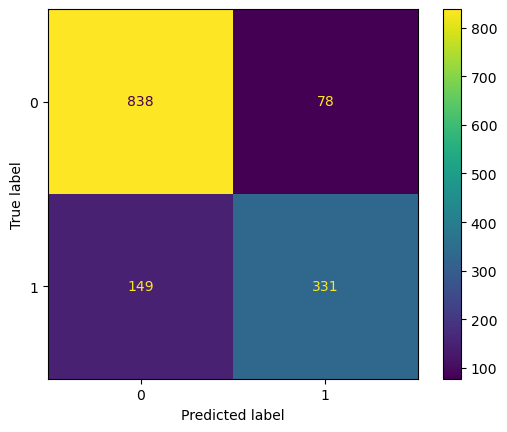

In [75]:
ConfusionMatrixDisplay.from_predictions(y_test_feng, y_test_pred)

plt.show()

In [76]:
print(classification_report(y_true = y_test_feng,
                            y_pred = y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       916
           1       0.81      0.69      0.74       480

    accuracy                           0.84      1396
   macro avg       0.83      0.80      0.81      1396
weighted avg       0.84      0.84      0.83      1396



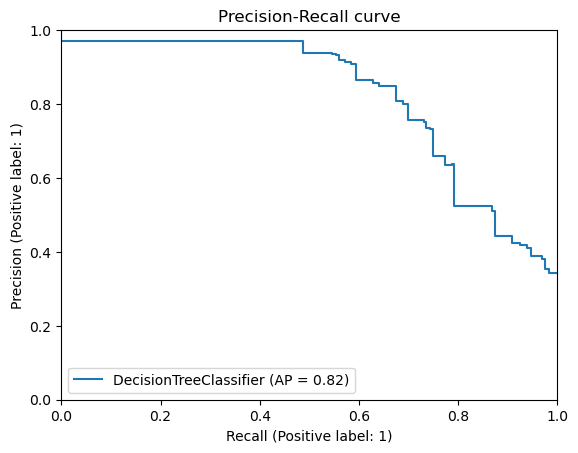

In [77]:
display = PrecisionRecallDisplay.from_estimator(final_model, X_test_feng, y_test_feng)
_ = display.ax_.set_title('Precision-Recall curve')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()